# V5: 条件付き確率分布

トークン間の条件付き確率関係を可視化し、モデルが学習した統計的構造を理解します。

## ライブラリのインポート

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import networkx as nx
from model_analyzer import ModelAnalyzer, InferenceEngine
from tqdm import tqdm

# Seabornのスタイル設定
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 10)

import japanize_matplotlib  # 日本語表示を有効化


## ModelAnalyzerとInferenceEngineの初期化

In [2]:
# モデルの読み込み
analyzer = ModelAnalyzer('../model.json')
engine = InferenceEngine(analyzer)

モデル読み込み完了: vocab_size=27, n_layer=1, n_embd=16, block_size=16, n_head=4


## セクション1：条件付き確率行列の計算

In [3]:
# 全トークンに対して条件付き確率を計算
print("条件付き確率行列を計算中...")
print(f"語彙サイズ: {analyzer.vocab_size}")

# P(next_token | current_token)の行列を構築
prob_matrix = np.zeros((analyzer.vocab_size, analyzer.vocab_size))

for current_token_id in tqdm(range(analyzer.vocab_size)):
    # 現在トークンをコンテキストとして次トークン確率を計算
    context = [analyzer.BOS, current_token_id]
    probs = engine.get_token_probabilities(context)
    prob_matrix[current_token_id] = probs

print("\n計算完了！")

条件付き確率行列を計算中...
語彙サイズ: 27


100%|██████████| 27/27 [00:00<00:00, 1085.02it/s]


計算完了！


## セクション2：条件付き確率行列のヒートマップ

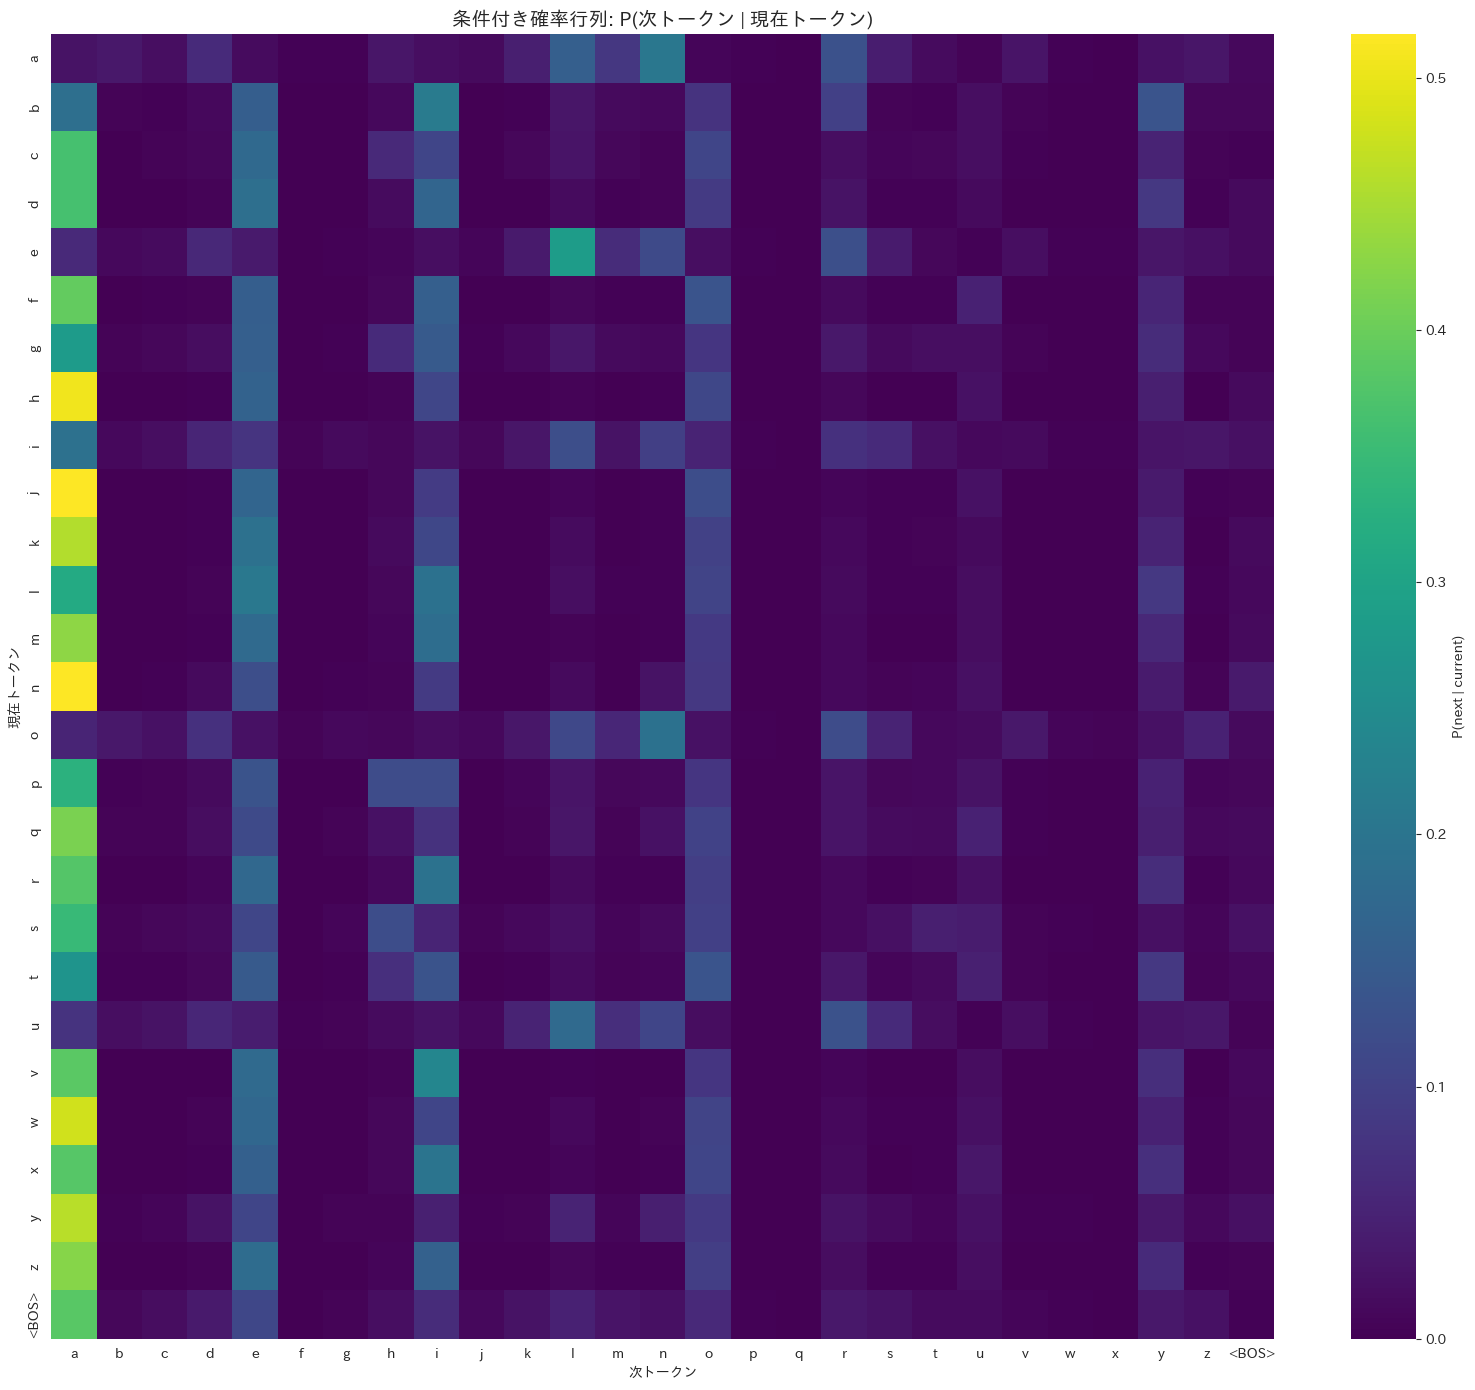

In [4]:
# トークンラベルを作成
token_labels = analyzer.uchars + ['<BOS>']

# ヒートマップで可視化
plt.figure(figsize=(16, 14))
sns.heatmap(
    prob_matrix,
    xticklabels=token_labels,
    yticklabels=token_labels,
    cmap='viridis',
    cbar_kws={'label': 'P(next | current)'},
    vmin=0,
    vmax=prob_matrix.max()
)
plt.title('条件付き確率行列: P(次トークン | 現在トークン)', fontsize=14)
plt.xlabel('次トークン')
plt.ylabel('現在トークン')
plt.tight_layout()
plt.show()

## セクション3：トークン遷移グラフ

閾値: 0.1（これ以上の確率を持つ遷移のみ表示）

ノード数: 27
エッジ数: 86


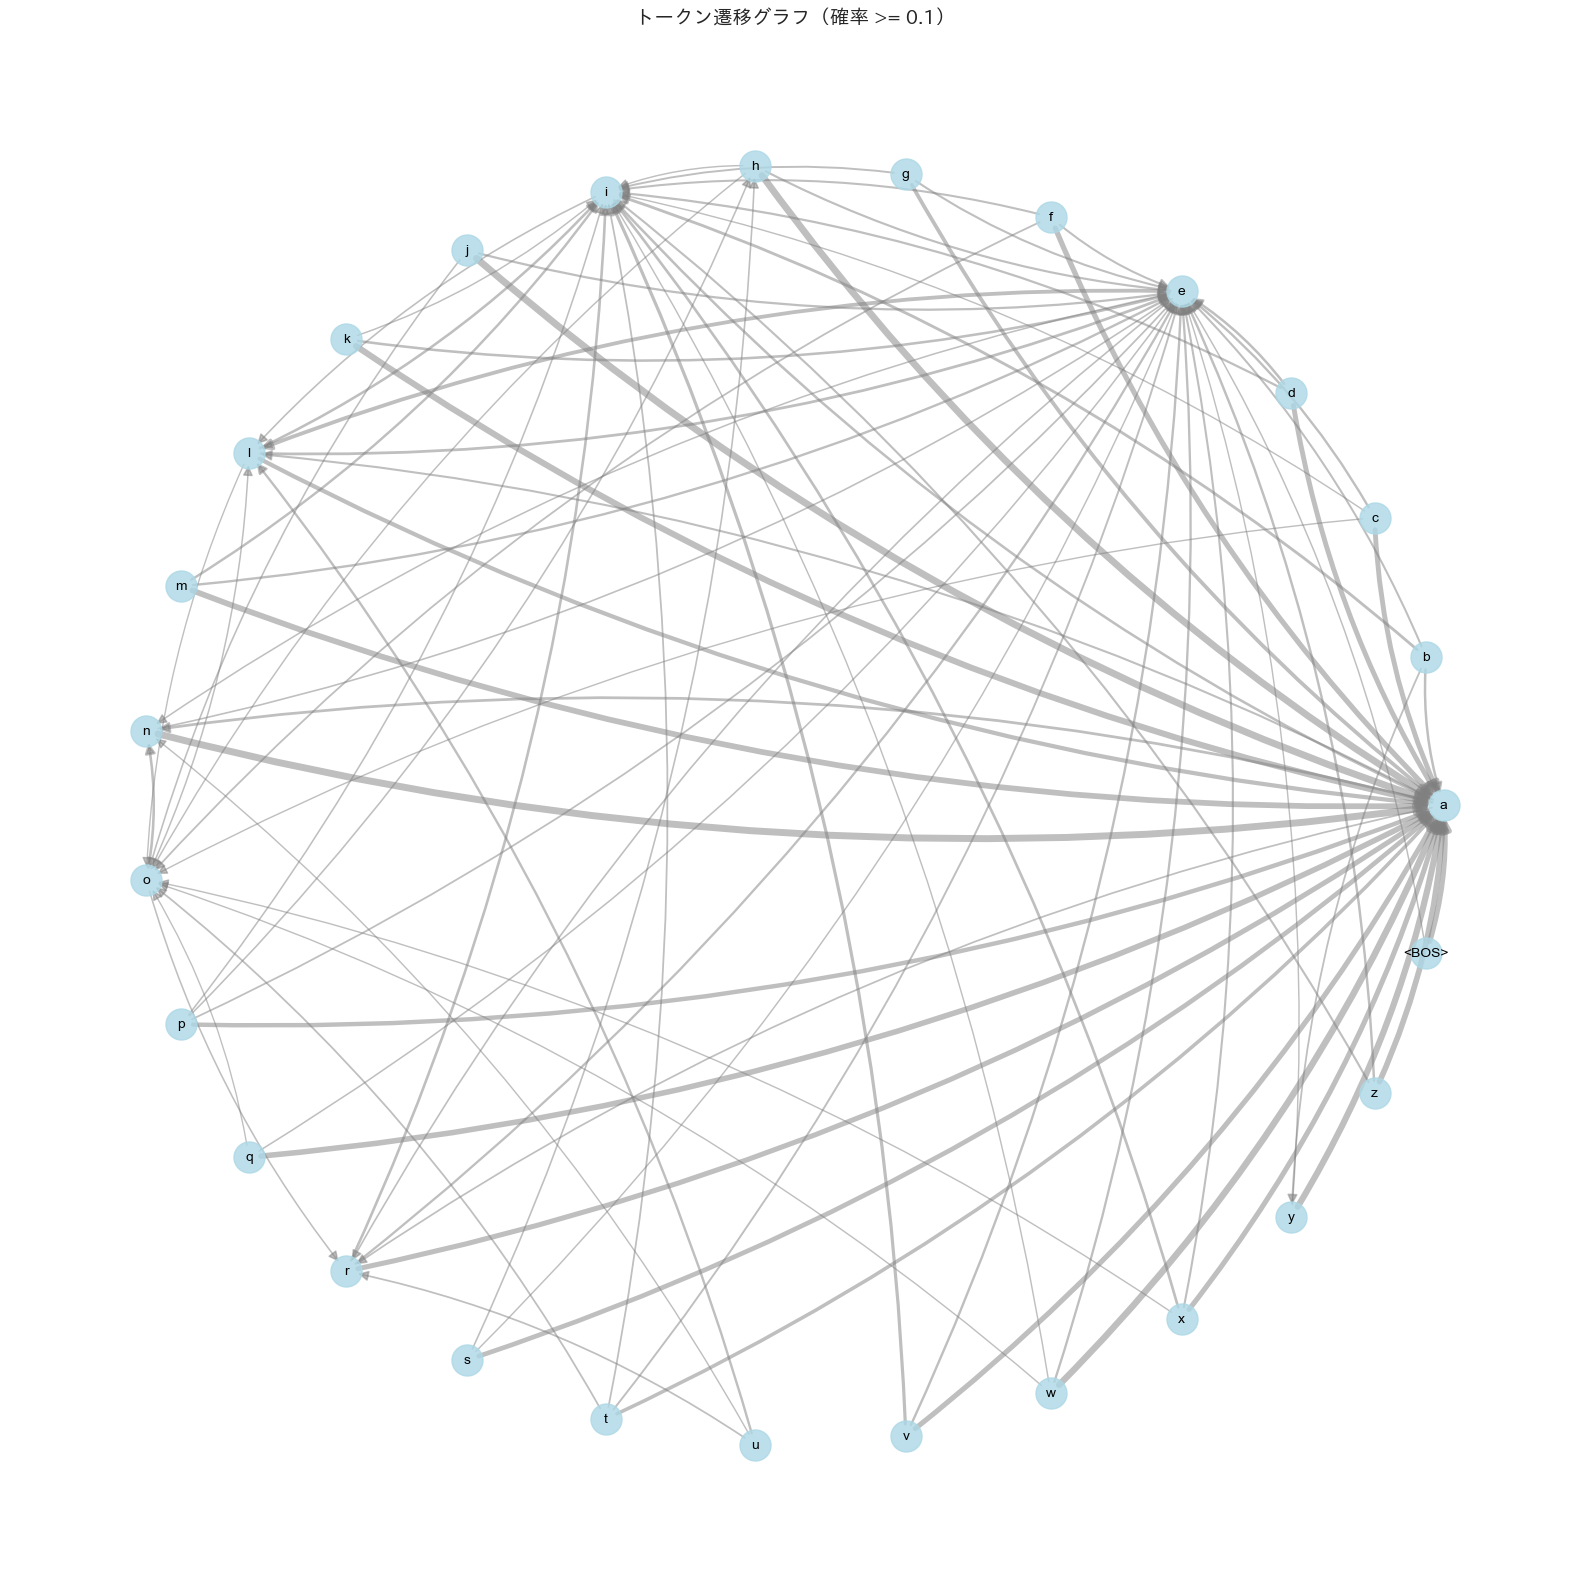

In [5]:
# 確率閾値以上の遷移のみを表示
threshold = 0.1
print(f"閾値: {threshold}（これ以上の確率を持つ遷移のみ表示）")

# 有向グラフを作成
G = nx.DiGraph()

# ノードを追加
for token_id, label in enumerate(token_labels):
    G.add_node(token_id, label=label)

# エッジを追加（確率が閾値以上のもの）
for i in range(analyzer.vocab_size):
    for j in range(analyzer.vocab_size):
        prob = prob_matrix[i, j]
        if prob >= threshold:
            G.add_edge(i, j, weight=prob)

print(f"\nノード数: {G.number_of_nodes()}")
print(f"エッジ数: {G.number_of_edges()}")

# グラフを描画
plt.figure(figsize=(16, 16))
pos = nx.circular_layout(G)  # 円周レイアウト

# ノードラベルを作成
node_labels = {i: token_labels[i] for i in G.nodes()}

# エッジの重みに基づいて太さを設定
edges = G.edges()
weights = [G[u][v]['weight'] for u, v in edges]
max_weight = max(weights) if weights else 1
edge_widths = [w / max_weight * 5 for w in weights]  # 最大5ポイント

# グラフを描画
nx.draw_networkx_nodes(G, pos, node_size=500, node_color='lightblue', alpha=0.8)
nx.draw_networkx_labels(G, pos, node_labels, font_size=10)
nx.draw_networkx_edges(G, pos, width=edge_widths, alpha=0.5, 
                       edge_color='gray', arrows=True, arrowsize=15,
                       connectionstyle='arc3,rad=0.1')

plt.title(f'トークン遷移グラフ（確率 >= {threshold}）', fontsize=14)
plt.axis('off')
plt.tight_layout()
plt.show()

## セクション4：高頻度遷移パターン

In [6]:
# 確率が高い遷移のトップ20を表示
top_k = 20
transitions = []

for i in range(analyzer.vocab_size):
    for j in range(analyzer.vocab_size):
        prob = prob_matrix[i, j]
        transitions.append({
            '現在トークン': token_labels[i],
            '次トークン': token_labels[j],
            '確率': prob
        })

# DataFrameを作成してソート
transitions_df = pd.DataFrame(transitions)
transitions_df = transitions_df.sort_values('確率', ascending=False).head(top_k)

# 表示
print(f"\n高頻度遷移パターン（上位{top_k}件）")
print("=" * 50)
styled_df = transitions_df.reset_index(drop=True).style.background_gradient(
    subset=['確率'], 
    cmap='YlOrRd'
).format({'確率': '{:.4f}'})

display(styled_df)

# 解釈コメント
print("\n解釈:")
print("- 表の上位は、学習データで頻繁に出現する文字の組み合わせを反映しています")
print("- 例: 'e'の後に'a'が来る確率が高い → 'ea'という組み合わせが多い")
print("- モデルは文字レベルのn-gram統計を学習していることがわかります")


高頻度遷移パターン（上位20件）


,現在トークン,次トークン,確率
0,n,a,0.5173
1,j,a,0.5173
2,h,a,0.5069
3,w,a,0.4802
4,y,a,0.4624
5,k,a,0.4573
6,m,a,0.4285
7,z,a,0.4225
8,q,a,0.4137
9,f,a,0.3922



解釈:
- 表の上位は、学習データで頻繁に出現する文字の組み合わせを反映しています
- 例: 'e'の後に'a'が来る確率が高い → 'ea'という組み合わせが多い
- モデルは文字レベルのn-gram統計を学習していることがわかります


## セクション5：特定コンテキストの次トークン分布

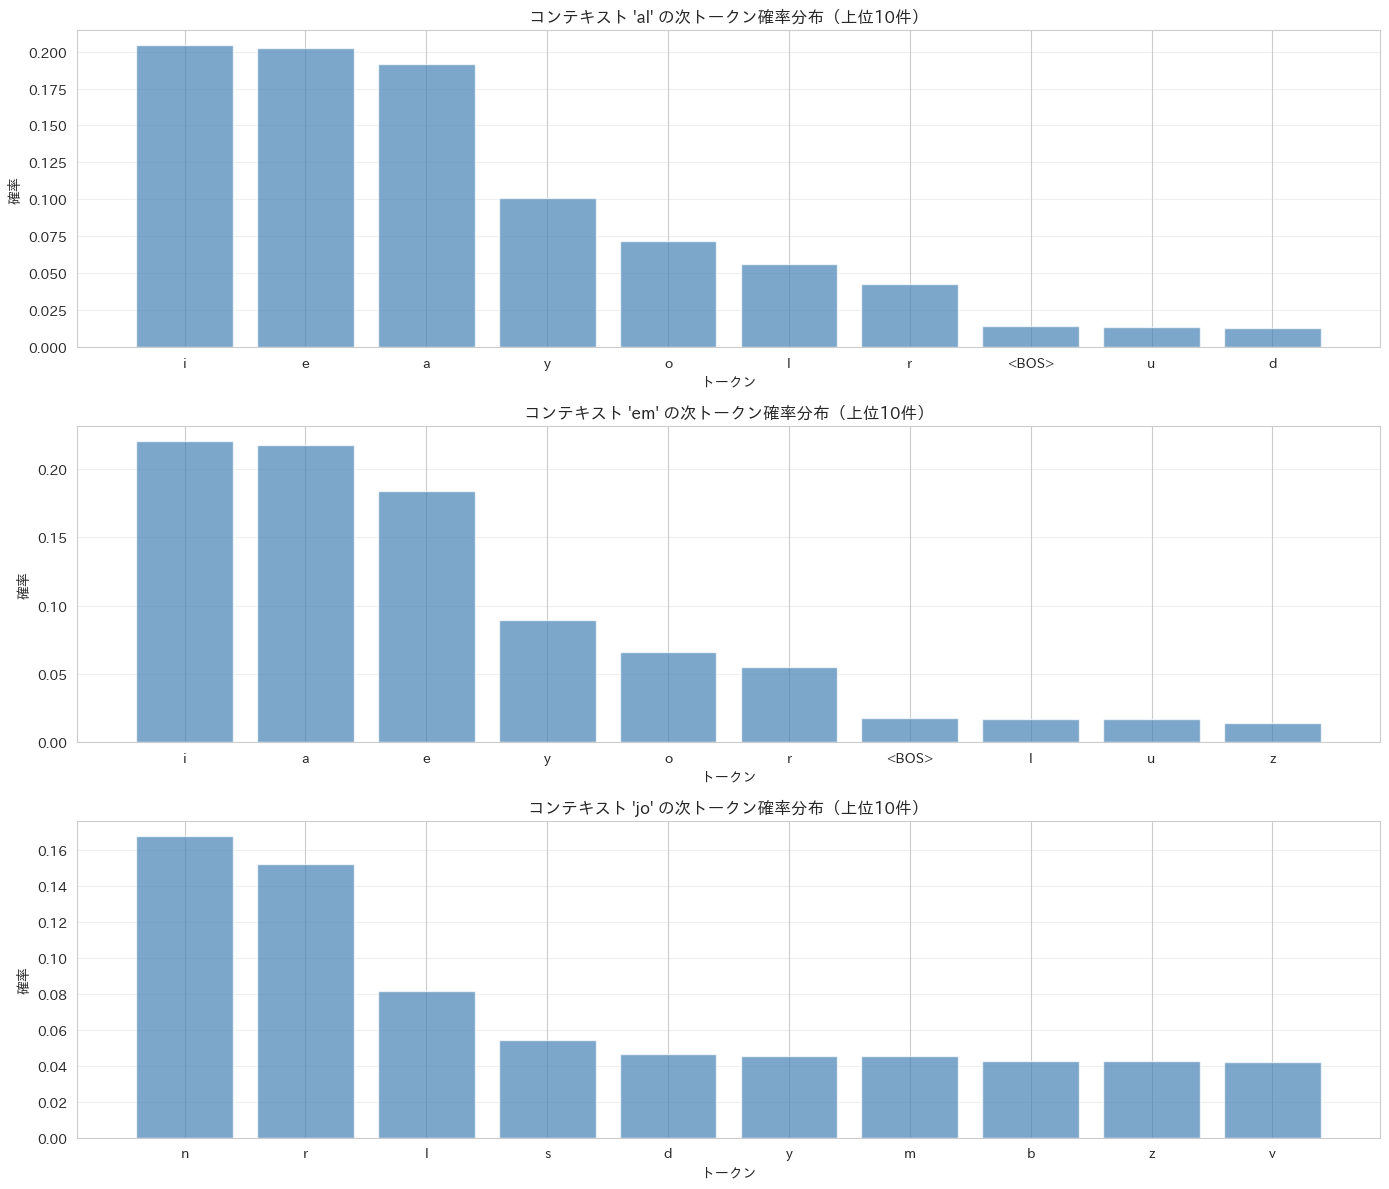

In [7]:
# 特定のコンテキストに対する次トークン確率を比較
test_contexts = ['al', 'em', 'jo']

fig, axes = plt.subplots(len(test_contexts), 1, figsize=(14, 4 * len(test_contexts)))
if len(test_contexts) == 1:
    axes = [axes]

for idx, context_str in enumerate(test_contexts):
    # コンテキストをトークンIDに変換
    context_ids = [analyzer.BOS] + analyzer.tokenize(context_str)
    
    # 次トークン確率を取得
    probs = engine.get_token_probabilities(context_ids)
    
    # 上位10件を取得
    top_k = 10
    top_indices = np.argsort(probs)[-top_k:][::-1]
    
    # データを準備
    top_tokens = [token_labels[i] for i in top_indices]
    top_probs = [probs[i] for i in top_indices]
    
    # 棒グラフで表示
    ax = axes[idx]
    ax.bar(top_tokens, top_probs, color='steelblue', alpha=0.7)
    ax.set_title(f"コンテキスト '{context_str}' の次トークン確率分布（上位{top_k}件）", fontsize=12)
    ax.set_xlabel('トークン')
    ax.set_ylabel('確率')
    ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## セクション6：Plotlyインタラクティブ棒グラフ

In [8]:
# 複数のコンテキストを比較するインタラクティブグラフ

# 各コンテキストのデータを準備
top_k = 10
data_traces = []

for context_str in test_contexts:
    context_ids = [analyzer.BOS] + analyzer.tokenize(context_str)
    probs = engine.get_token_probabilities(context_ids)
    
    top_indices = np.argsort(probs)[-top_k:][::-1]
    top_tokens = [token_labels[i] for i in top_indices]
    top_probs = [probs[i] for i in top_indices]
    
    trace = go.Bar(
        x=top_tokens,
        y=top_probs,
        name=f"'{context_str}'",
        hovertemplate='トークン: %{x}<br>確率: %{y:.4f}<extra></extra>'
    )
    data_traces.append(trace)

# グラフを作成
fig = go.Figure(data=data_traces)

fig.update_layout(
    title='コンテキスト別次トークン確率分布（インタラクティブ）',
    xaxis_title='次トークン',
    yaxis_title='確率',
    barmode='group',
    width=1000,
    height=600,
    hovermode='x unified'
)

fig.show()

## まとめ

このNotebookでは、トークン間の条件付き確率分布を可視化しました:

### 主な発見
1. **条件付き確率行列**: 全トークン間の遷移確率を一覧表示
2. **遷移グラフ**: 高確率な遷移をグラフ構造で可視化
3. **高頻度パターン**: 学習データの統計的構造を反映した遷移パターン
4. **コンテキスト依存**: 同じ文字でも前のコンテキストにより次の文字の分布が変化

### 観察ポイント
- モデルは文字レベルのn-gram統計をうまく学習している
- 特定の文字の組み合わせで強い遷移傾向が見られる
- コンテキストにより次トークンの確率分布が大きく異なる

これで全5つのNotebookによる可視化が完了しました！